# Анализ лояльности пользователей Яндекс Афиши

- Автор: Мосолов Андрей
- Дата: 24.10.2025

Предоставлен набор данных о билетной выручке по пользователям и мероприятиям полученный на сервисе Афиши.

Необходимо собрать информацию о типичном пользователе и выявить критерии для удержания.

---

<a name="0"></a>
1. [Загрузка данных и их предобработка](#1)
2. [Предобработка данных](#2)
3. [Создание профиля пользователя](#3)
4. [Исследовательский анализ данных](#4)
5. [Общий вывод и рекомендации](#5)
6. [Финализация проекта и публикация в Git](#6)

## Этапы выполнения проекта
<a name="1"></a>
### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik

Defaulting to user installation because normal site-packages is not writeable


In [89]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phik import phik_matrix
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

In [88]:
# загружаем переменные окружения
try:
    if not os.path.exists('0.env'):
        raise FileNotFoundError("Конфигурационный файл не найден")
        
    load_dotenv('0.env')
    
except Exception as e:
    print(f"Ошибка при загрузке 0.env: {e}")

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

#print(db_config)

In [6]:
# Настройки
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

query = '''
SELECT user_id,
device_type_canonical,
order_id,
created_dt_msk AS order_dt,
created_ts_msk AS order_ts,
currency_code,
revenue,
tickets_count,
EXTRACT(DAYS FROM (created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))) AS days_since_prev,
event_id,
event_name_code AS event_name,
event_type_main,
service_name,
region_name,
city_name
FROM afisha.purchases p
JOIN afisha.events e USING(event_id)
JOIN afisha.city c ON c.city_id = e.city_id
JOIN afisha.regions r ON r.region_id = c.region_id
WHERE device_type_canonical IN ('mobile','desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id ASC
'''

In [7]:
engine = create_engine(connection_string)

In [8]:
try:
    df = pd.read_sql_query(query, con=engine)
except Exception as error:
    print(f"df: ошибка загрузки: {error}")

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [9]:
df.shape

(290611, 15)

In [10]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [11]:
df.sample(10, random_state=25)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
158996,8187dac4be757a0,mobile,3937911,2024-08-03,2024-08-03 11:54:48,rub,0.00,2,0.0,553512,9a2ac622-9dbc-4c12-96a5-ad7bafc6e508,другое,Билеты без проблем,Каменевский регион,Глиногорск
221409,b8c389ce2e04938,mobile,3655828,2024-08-02,2024-08-02 11:50:35,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск
146199,78c9b8cb7d8de87,mobile,3626915,2024-09-03,2024-09-03 00:01:28,rub,824.40,2,0.0,17584,df404a04-58d5-47ca-a35e-ae62c7557eff,театр,Билеты без проблем,Озернинский край,Лесоярич
254089,de04aa93dd46a51,desktop,7928746,2024-09-20,2024-09-20 16:28:10,rub,779.51,3,0.0,205660,de6909af-3c85-4fa8-a53b-af33676c07c6,театр,Тебе билет!,Тепляковская область,Горнодолинск
5181,02ea4583333f064,mobile,947460,2024-09-29,2024-09-29 10:29:37,rub,166.19,1,0.0,557810,e95e330f-a56a-492c-891b-d8bdcb9f8daa,другое,Мой билет,Островогорский округ,Лесозерск
20066,0beb8fc0c0a9ce1,mobile,1352793,2024-09-15,2024-09-15 12:16:50,rub,162.18,3,0.0,505700,08a605b8-ca9f-4acf-836e-d1d1c1e412b8,театр,Лови билет!,Североярская область,Озёрск
109263,4ee904ac8cb57a9,mobile,8132993,2024-10-31,2024-10-31 15:36:12,rub,207.47,3,0.0,579070,126ecbf3-f506-4083-83f4-69eeca8d48fe,другое,Мой билет,Каменевский регион,Глиногорск
146841,7a46482b64e1e9a,desktop,7547483,2024-10-18,2024-10-18 18:07:44,rub,926.94,2,0.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
140679,72e31a44b986ad0,mobile,7523732,2024-08-12,2024-08-12 00:37:51,rub,369.91,3,0.0,372088,62bd5096-54c0-4ab4-80ad-c1e070f4bb1d,театр,Прачечная,Каменевский регион,Глиногорск
233890,c9091531efee76f,mobile,113507,2024-10-04,2024-10-04 17:43:45,rub,2273.46,6,57.0,559595,272e048e-91f0-4899-92ca-ce7299cb36b3,концерты,Билеты в руки,Североярская область,Озёрск


In [12]:
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584360,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.350509,147423.078841


In [13]:
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

---
Выгружено 290611 записей, данные 2024г за период: с июня до конца октября. Пропуски есть только в созданном столбце `days_since_prev` - 21933, поле содержит int значения, но имеет тип float из-за пропусков.

Выручка в диапазоне от -90 до 81000р, среднее 625 отличается от медианы 356, возможно выбросы.
Для билетов разброс значений от 1 до 57, при этом среднее 2.75 не сильно отличается от медианы 3.

---
<a name="2"></a>
###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [14]:
try:
    df_tenge = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv")
except Exception as error:
    print(f"df_tenge: ошибка загрузки: {error}")

In [15]:
df_tenge.info()
df_tenge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [16]:
# привести столбец к типу дата
df_tenge['data'] = pd.to_datetime(df_tenge['data'], format='%Y-%m-%d')
df_tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [17]:
# заполнить выручку в рублях
def currency_rub(row):
    if row.currency_code == 'kzt':  
        if df_tenge[df_tenge.data == row.order_dt].shape[0] != 0:
            curs = df_tenge.loc[df_tenge.data == row.order_dt, 'curs']
            if not curs.isna().iloc[0]:
                return row.revenue * df_tenge.loc[df_tenge.data == row.order_dt, 'curs'].iloc[0] / 100
        
        return None
    else:    
        return row.revenue
    
df['revenue_rub'] = df.apply(currency_rub, axis=1)

In [18]:
df[df.currency_code == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [19]:
missing_percentage = round(df.isna().sum() / len(df) * 100,2) 
missing_df = pd.DataFrame({
    'Количество пропусков': df.isna().sum(),
    'Процент пропусков (%)': missing_percentage
})
print("\nАнализ пропущенных значений:")
display(missing_df)


Анализ пропущенных значений:


,Количество пропусков,Процент пропусков (%)
user_id,0,0.00
device_type_canonical,0,0.00
order_id,0,0.00
order_dt,0,0.00
order_ts,0,0.00
currency_code,0,0.00
revenue,0,0.00
tickets_count,0,0.00
days_since_prev,21933,7.55
event_id,0,0.00


In [20]:
# пропуски только в days_since_prev, смотрим на типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [21]:
# Анализ категориальных значений
cat_percentage = 100 - round(df.nunique().sort_values(ascending=True) / len(df) * 100,2) 
cat_df = pd.DataFrame({
    'Количество категорий': df.nunique().sort_values(ascending=True),
    'Процент от общего числа строк (%)': cat_percentage
})
print("\nАнализ категориальных значений:")
display(cat_df)


Анализ категориальных значений:


,Количество категорий,Процент от общего числа строк (%)
device_type_canonical,2,100.00
currency_code,2,100.00
event_type_main,7,100.00
tickets_count,22,99.99
service_name,36,99.99
region_name,81,99.97
days_since_prev,149,99.95
order_dt,153,99.95
city_name,352,99.88
event_name,15248,94.75


In [22]:
# категория для столбцов с малым числом уникальных значений
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]

for col in cat_cols:
    df[col] = df[col].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

In [24]:
# попытка понизить размерность int
for col in ('order_id','event_id','tickets_count'):
    pd.to_numeric(df[col], downcast='integer')
    
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='unsigned')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  uint8         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

In [26]:
# нет явных дубликатов, при уникальном order_id так и должно быть
df.duplicated().sum()

0

In [27]:
# ищем неявные дубликаты
df.duplicated(df.columns.difference(['order_id', 'event_id']).tolist()).sum()

31

In [28]:
# есть 31 записи с разным order_id, но похожим данными. Не знаю как интерпретировать - сбой при формировании заказа?
df[df.duplicated(df.columns.difference(['order_id', 'event_id']).tolist(), False)]

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
11758,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,69.820000
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград,69.820000
53681,206ea45ec11d478,mobile,1935113,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,Билеты в руки,Каменевский регион,Глиногорск,601.690000
53682,206ea45ec11d478,mobile,1935171,2024-10-29,2024-10-29 16:46:54,rub,601.69,2,0.0,442183,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,Билеты в руки,Каменевский регион,Глиногорск,601.690000
57179,2564e3703075008,mobile,160893,2024-10-30,2024-10-30 10:04:15,rub,11.23,2,0.0,589005,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,другое,Лови билет!,Яблоневская область,Горяново,11.230000
57181,2564e3703075008,mobile,160922,2024-10-30,2024-10-30 10:04:15,rub,11.23,2,0.0,589005,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,другое,Лови билет!,Яблоневская область,Горяново,11.230000
74469,35c4c43710a1e8c,mobile,4536123,2024-09-28,2024-09-28 13:43:54,rub,1891.93,6,0.0,568022,97f14a5a-80d5-49fd-aa1c-0b7b6b59ae48,концерты,Мир касс,Светополянский округ,Глиноград,1891.930000
74472,35c4c43710a1e8c,mobile,4536210,2024-09-28,2024-09-28 13:43:54,rub,1891.93,6,0.0,568022,97f14a5a-80d5-49fd-aa1c-0b7b6b59ae48,концерты,Мир касс,Светополянский округ,Глиноград,1891.930000
83928,3ee7dc2e115847f,mobile,3363798,2024-06-25,2024-06-25 07:32:08,rub,59.19,3,0.0,277504,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,выставки,Билеты в руки,Нежинская область,Каменёвка,59.190000
83931,3ee7dc2e115847f,mobile,3363711,2024-06-25,2024-06-25 07:32:08,rub,59.19,3,0.0,277504,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,выставки,Билеты в руки,Нежинская область,Каменёвка,59.190000


In [29]:
# удаление 31 дубликата
duplicates = df[df.duplicated(df.columns.difference(['order_id', 'event_id']).tolist())]
df = df.drop(duplicates.index).reset_index(drop=True)

In [30]:
# дубликаты удалены
df.duplicated(df.columns.difference(['order_id', 'event_id']).tolist()).sum()

0

In [31]:
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,2.905800e+05,290580,290580,290580.000000,290580.000000,268647.000000,290580.000000,290580.000000
mean,4.326215e+06,2024-09-01 22:35:57.769977088,2024-09-02 13:30:39.004769792,625.595836,2.754322,3.222753,438015.901277,555.581198
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000,-90.760000
25%,2.163568e+06,2024-07-30 00:00:00,2024-07-30 11:53:36.750000128,116.850000,2.000000,0.000000,361758.500000,113.970000
50%,4.326322e+06,2024-09-12 00:00:00,2024-09-12 14:01:05,356.020000,3.000000,0.000000,498278.500000,351.140000
75%,6.488381e+06,2024-10-09 00:00:00,2024-10-09 15:57:33.249999872,810.130000,4.000000,1.000000,546285.500000,802.050000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000,81174.540000
std,2.497556e+06,NaN,NaN,1227.738613,1.170604,11.351112,147426.206117,875.520729


In [32]:
# график hist
def hist(data, column, title=None, xlabel=None, ylabel=None, bins=50, kde=True, figsize=(12, 6)):
    values = data[column].dropna()
    
    plt.figure(figsize=figsize)

    sns.histplot(
        data=values,
        bins=bins,
        kde=kde,
        stat='count'
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    
    plt.show()

In [33]:
# график boxplot
def boxplot(data, column, title=None, xlabel=None, figsize=(12, 2)):
    values = data[column].dropna()
    
    plt.figure(figsize=figsize)
    
    plt.boxplot(
        values,
        vert=False,  
        flierprops=dict(markerfacecolor='r', marker='o')
    )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    
    plt.show()

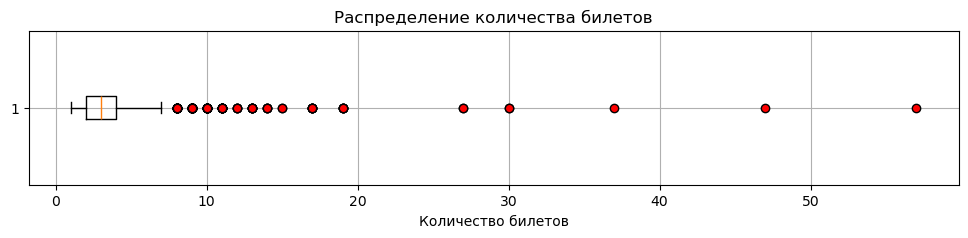

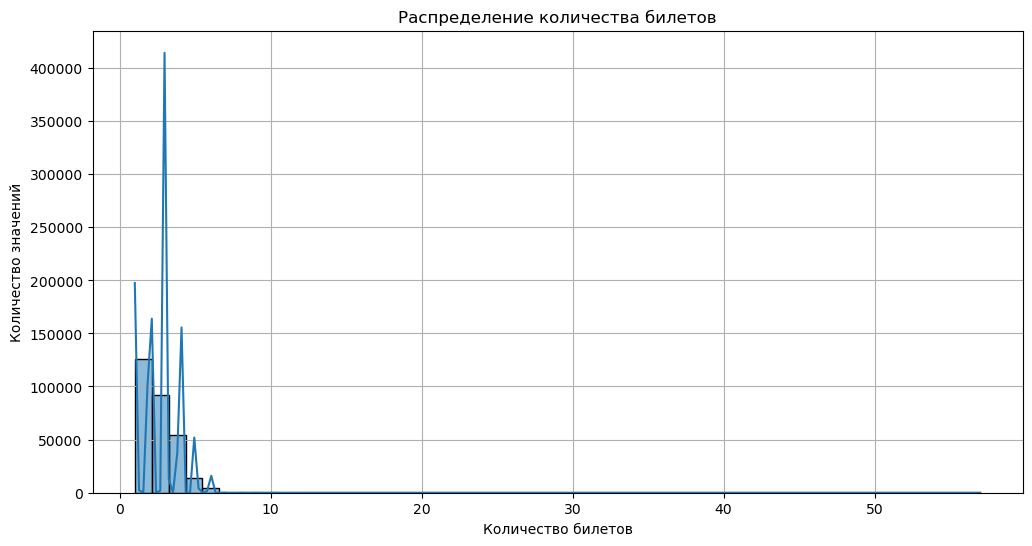

In [34]:
boxplot(df, 'tickets_count', 'Распределение количества билетов', 'Количество билетов')
hist(df, 'tickets_count', 'Распределение количества билетов', 'Количество билетов','Количество значений')

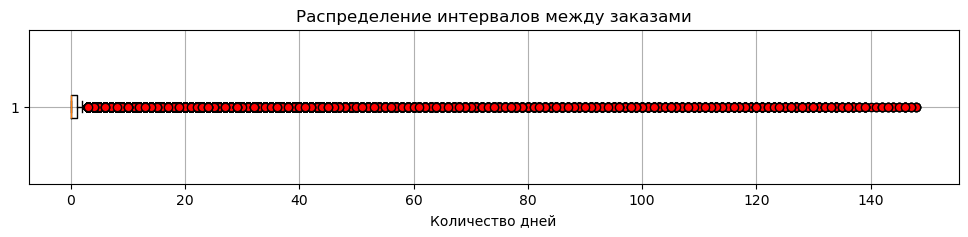

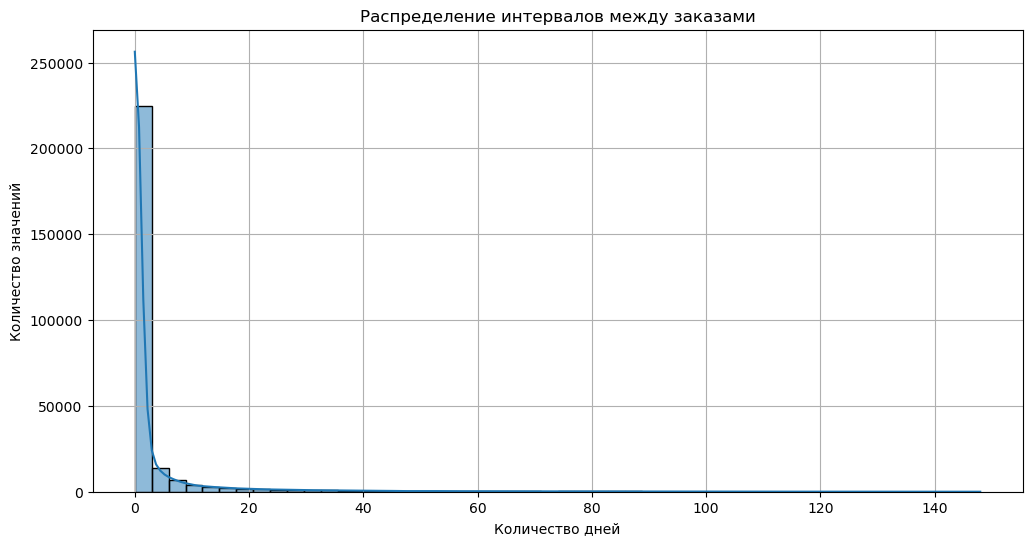

In [35]:
boxplot(df, 'days_since_prev', 'Распределение интервалов между заказами', 'Количество дней')
hist(df, 'days_since_prev', 'Распределение интервалов между заказами', 'Количество дней','Количество значений')

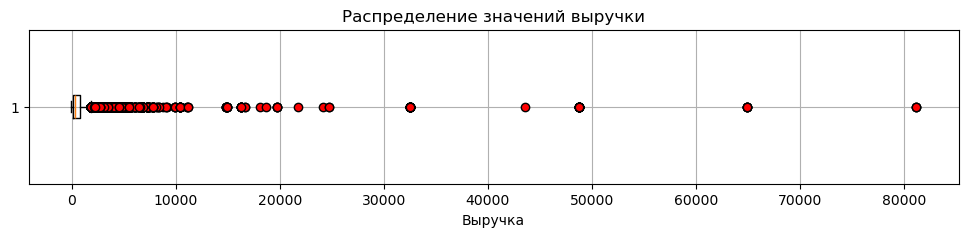

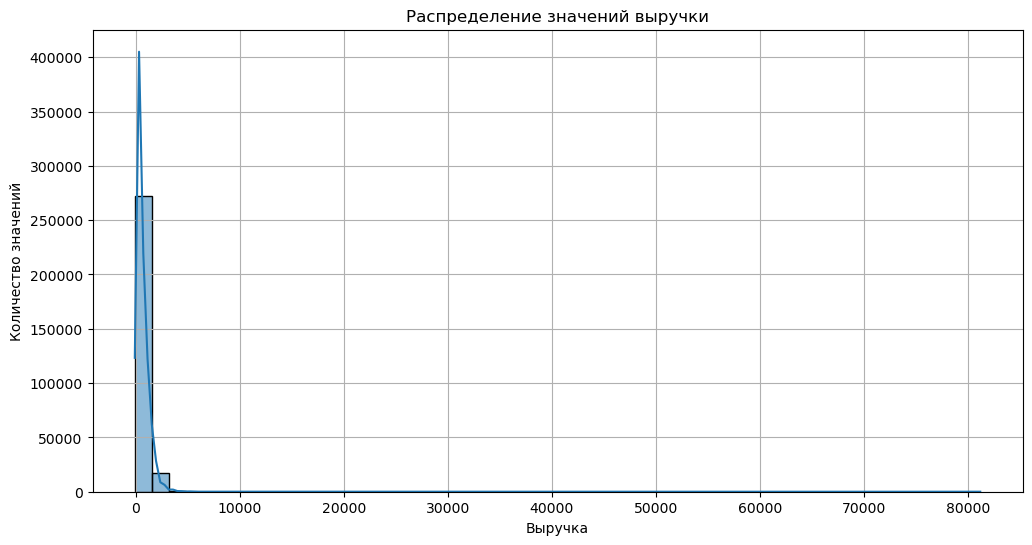

In [36]:
boxplot(df, 'revenue_rub', 'Распределение значений выручки', 'Выручка')
hist(df, 'revenue_rub', 'Распределение значений выручки', 'Выручка','Количество значений')

In [37]:
p99 = np.percentile(df.revenue_rub, 99)
print(f"99-й процентиль: {p99:.2f}")

lendf = len(df)
df = df[df.revenue_rub <= p99].reset_index(drop=True)
print(f"Было строк: {lendf}. После фильтрации: {len(df)}. Удалено: {lendf - len(df)}")

99-й процентиль: 2628.42
Было строк: 290580. После фильтрации: 287755. Удалено: 2825


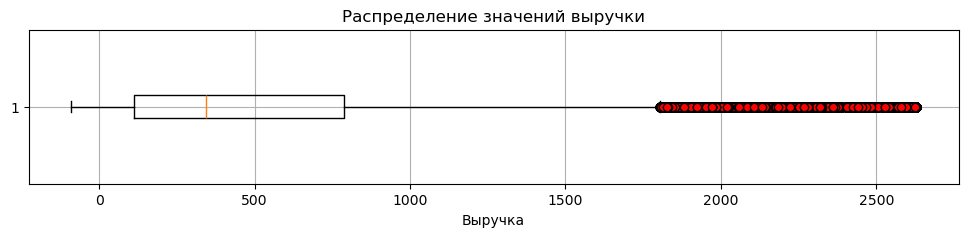

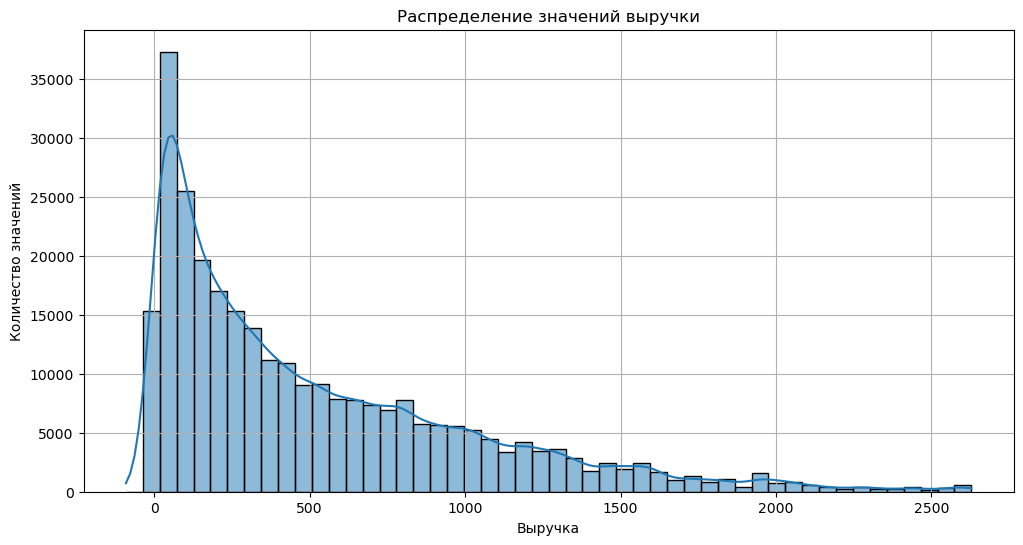

In [38]:
# Проверим распределение выручки после удаления части выбросов
boxplot(df, 'revenue_rub', 'Распределение значений выручки', 'Выручка')
hist(df, 'revenue_rub', 'Распределение значений выручки', 'Выручка','Количество значений')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287755 entries, 0 to 287754
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287755 non-null  object        
 1   device_type_canonical  287755 non-null  category      
 2   order_id               287755 non-null  int64         
 3   order_dt               287755 non-null  datetime64[ns]
 4   order_ts               287755 non-null  datetime64[ns]
 5   currency_code          287755 non-null  category      
 6   revenue                287755 non-null  float64       
 7   tickets_count          287755 non-null  uint8         
 8   days_since_prev        266019 non-null  float64       
 9   event_id               287755 non-null  int64         
 10  event_name             287755 non-null  object        
 11  event_type_main        287755 non-null  category      
 12  service_name           287755 non-null  cate

---
Осталось 287755 записей. Удален 31 неявный дубликат и 2825 записей с выбросами по значению выручки.

Столбцы приведены к категориальному типу `device_type_canonical`, `currency_code`, `event_type_main`, `service_name`, `region_name`, `city_name`. Удалось снизить размерность типа int для `tickets_count`. Размер *memory usage* изменился с 35.5+ MB до 22.0+ MB.

Создан столбец `revenue_rub` полученный в результате перевода значений выручки из тенге в рубли.

---
<a name="3"></a>
### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [40]:
df_user = df.sort_values('order_dt')

df_user = df_user.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_per_order=('revenue_rub', 'mean'),
    avg_tickets_per_order=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
)

df_user.head()

,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders
user_id,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0


In [41]:
# округление средних значений
for col in ('avg_revenue_per_order','avg_tickets_per_order','avg_days_between_orders'):
    df_user[col] = df_user[col].round(2)

In [42]:
# добавить признаки по количеству заказов
df_user['is_two'] = df_user.total_orders >= 2
df_user['is_five'] = df_user.total_orders >= 5

df_user.head()

,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,NaN,False,False
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.0,True,False
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.0,True,False
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,NaN,False,False
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,True,False


---
Подготовлен профиль пользователя с агрегированными значениями по числовым показателям, добавлены столбцы: `is_two` — совершил ли пользователь 2 и более заказа, `is_five` — совершил ли пользователь 5 и более заказов.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [43]:
# число пользователей в выборке
len(df_user)

21854

In [44]:
# средняя выручка с одного заказа
df_user.avg_revenue_per_order.mean()

544.3903267136451

In [45]:
# доля пользователей с 2 заказами
df_user.is_two.mean()

0.6170952686007138

In [46]:
# доля пользователей с 5 заказами
df_user.is_five.mean()

0.2900155577926238

In [47]:
# смотрим на остальные числовые показатели
df_user.describe()

,first_order_date,last_order_date,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders
count,21854,21854,21854.000000,21854.000000,21854.000000,13513.000000
mean,2024-08-09 22:54:06.490344960,2024-09-18 08:06:52.482840832,13.167155,544.390327,2.743134,15.851758
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,-10.770000,1.000000,0.000000
25%,2024-06-25 00:00:00,2024-08-25 00:00:00,1.000000,212.922500,2.000000,1.000000
50%,2024-08-09 00:00:00,2024-10-03 00:00:00,2.000000,467.285000,2.750000,8.000000
75%,2024-09-23 00:00:00,2024-10-22 00:00:00,5.000000,763.910000,3.080000,20.430000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,10181.000000,2628.420000,11.000000,148.000000
std,NaN,NaN,121.662500,431.594089,0.913081,22.306087


Количество заказов имеет среднее значение 13.17 и медиану 2 - есть выбросы. Минимально - 1 заказ, максимально - 10181.

Для билетов среднее 2.74 и медиана 2.75 близки, минимальное значение - 1 билет, максимальное - 11.

Дней между заказами минимально - 0, максимально - 148. Среднее 15.85 больше медианы 8 - возможны выбросы.

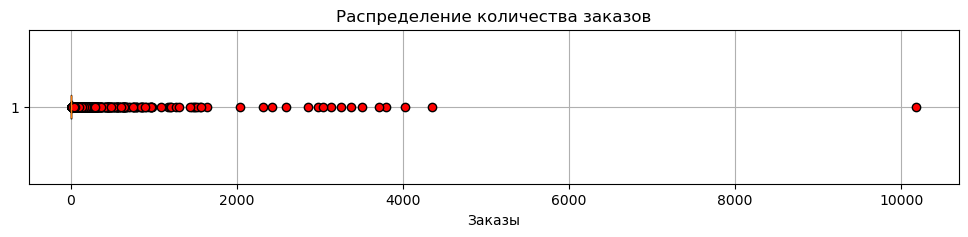

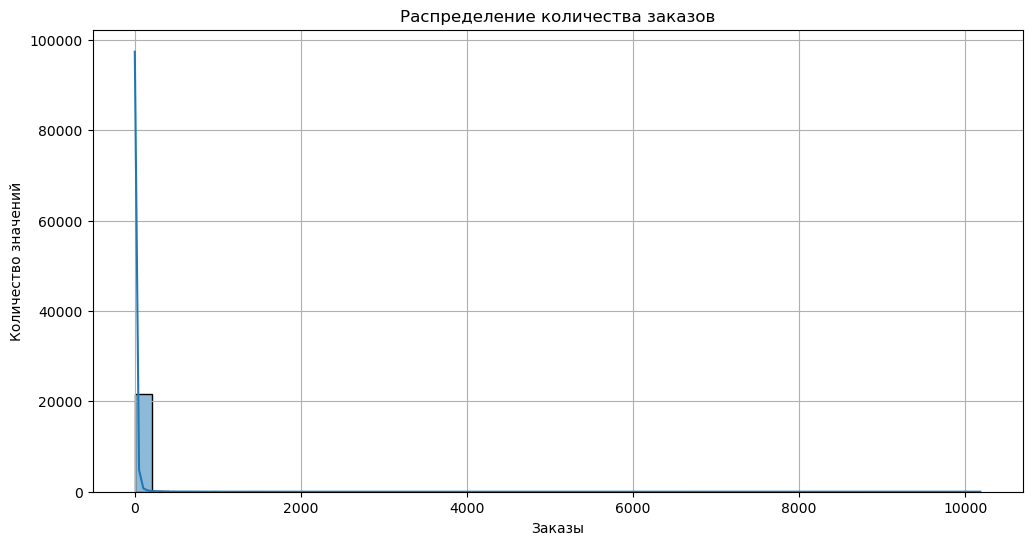

In [48]:
# по количеству заказов максимальное значение выделяется сильно, проверим и отфильтруем.
boxplot(df_user, 'total_orders', 'Распределение количества заказов', 'Заказы')
hist(df_user, 'total_orders', 'Распределение количества заказов', 'Заказы','Количество значений')

In [49]:
p95 = np.percentile(df_user.total_orders, 95)
print(f"95-й процентиль: {p95:.2f}")

lendf = len(df_user)
df_user = df_user[df_user.total_orders <= p95]
print(f"Было строк: {lendf}. После фильтрации: {len(df_user)}. Удалено: {lendf - len(df_user)}")

95-й процентиль: 31.35
Было строк: 21854. После фильтрации: 20761. Удалено: 1093


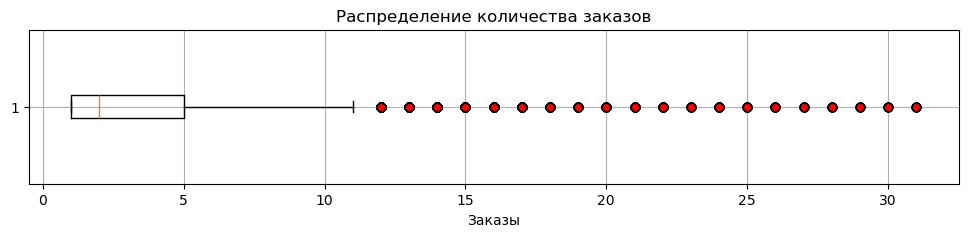

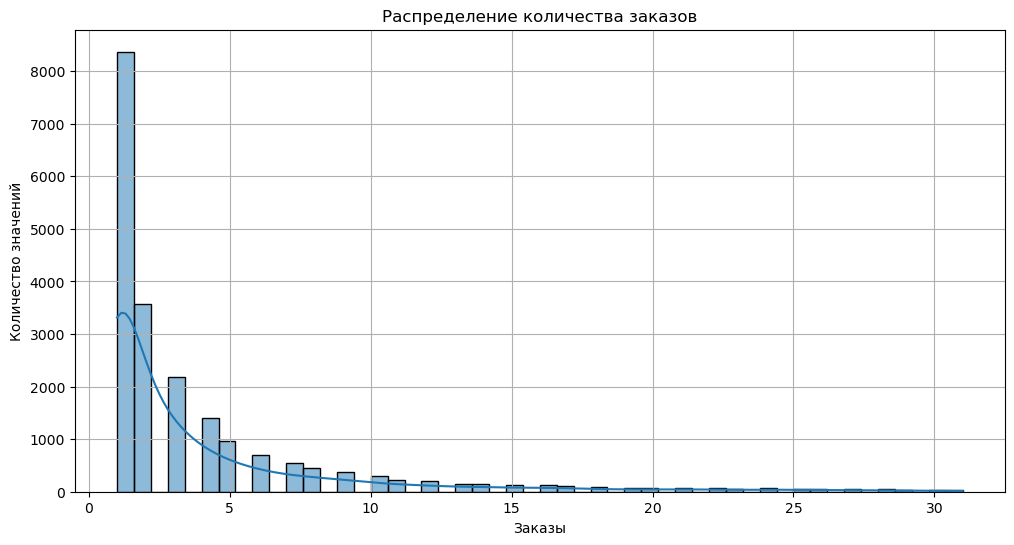

In [50]:
# проверим как изменилось распредление
boxplot(df_user, 'total_orders', 'Распределение количества заказов', 'Заказы')
hist(df_user, 'total_orders', 'Распределение количества заказов', 'Заказы','Количество значений')

In [51]:
# для заказов среднее 4 стало ближе к медиане 2 
df_user.describe()

,first_order_date,last_order_date,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders
count,20761,20761,20761.000000,20761.000000,20761.000000,12420.000000
mean,2024-08-13 04:22:15.195799808,2024-09-16 05:53:36.087856896,4.049323,546.671693,2.743601,17.056576
min,2024-06-01 00:00:00,2024-06-01 00:00:00,1.000000,-10.770000,1.000000,0.000000
25%,2024-07-01 00:00:00,2024-08-22 00:00:00,1.000000,202.490000,2.000000,1.000000
50%,2024-08-13 00:00:00,2024-09-30 00:00:00,2.000000,457.770000,2.750000,9.470000
75%,2024-09-25 00:00:00,2024-10-20 00:00:00,5.000000,780.800000,3.150000,22.170000
max,2024-10-31 00:00:00,2024-10-31 00:00:00,31.000000,2628.420000,11.000000,148.000000
std,NaN,NaN,5.112895,440.998397,0.934541,22.874908


In [52]:
# доля пользователей с 2 заказами
df_user.is_two.mean()

0.5969365637493377

In [53]:
# доля пользователей с 5 заказами
df_user.is_five.mean()

0.25263715620634847

---
Количество заказов имело среднее значение 13.17 и медиану 2 - есть выбросы. Минимально - 1 заказ, максимально - 10181.

После фильтрации по количеству заказов по 95 процентилю осталось записей: 20761. Удалено: 1093

Обновленные показатели: для количества заказов среднее значение 4.04 и медиана 2 - стали ближе. Минимально - 1 заказ, максимсально - 11, имеем более типичный набор значений для анализа.

Для билетов среднее 2.74 и медиана 2.75 близки, минимальное значение - 1 билет, максимальное - 11.

Дней между заказами минимально - 0, максимально - 148. Среднее 17.06 больше медианы 9.47 - стали чуть ближе, ничего не делаем, т.к. данные по интервалам в днях важны для цели исследования.

Средняя выручка с одного заказа 546.67, медиана 457.77. Минимальное значение - -10.77, максимальное - 2628.42.

Доли пользователей: с 2 заказами - 0.6 и с 5 заказами - 0.25.

---
<a name="4"></a>
### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [54]:
def group(dfby, column):
    dfby = df_user.groupby(column).agg(
        user_count=(column, 'count')
    )
    
    dfby['доля %'] = round(dfby.user_count / dfby.user_count.sum() * 100, 2)
    dfby = dfby.sort_values('user_count', ascending=False)
    
    return dfby

In [55]:
df_g = group(df, 'first_genre')
df_g

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\4218702668.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfby = df_user.groupby(column).agg(


,user_count,доля %
first_genre,,
концерты,9182,44.23
другое,5182,24.96
театр,4067,19.59
стендап,1072,5.16
спорт,769,3.70
выставки,399,1.92
ёлки,90,0.43


In [56]:
df_d = group(df, 'first_device')
df_d

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\4218702668.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfby = df_user.groupby(column).agg(


,user_count,доля %
first_device,,
mobile,17199,82.84
desktop,3562,17.16


In [57]:
df_r = group(df, 'first_region')
df_r.head(10)

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\4218702668.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfby = df_user.groupby(column).agg(


,user_count,доля %
first_region,,
Каменевский регион,6775,32.63
Североярская область,3610,17.39
Широковская область,1184,5.70
Озернинский край,661,3.18
Малиновоярский округ,511,2.46
Травяная область,469,2.26
Шанырский регион,461,2.22
Светополянский округ,435,2.10
Речиновская область,419,2.02


In [58]:
df_p = group(df, 'first_partner')
df_p.head(10)

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\4218702668.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfby = df_user.groupby(column).agg(


,user_count,доля %
first_partner,,
Билеты без проблем,4964,23.91
Мой билет,2844,13.70
Лови билет!,2724,13.12
Билеты в руки,2416,11.64
Облачко,2113,10.18
Весь в билетах,1228,5.91
Лучшие билеты,1132,5.45
Прачечная,551,2.65
Край билетов,438,2.11


---
Информация о первых заказах:

83% совершается с мобильных устройств. 

Топ 3 жанра (остальные имеют менее 10%)
- 44% концерты	(9182)
- 25% другое	(5182)
- 20% театр	(4067)

Лидируют явно два региона:
- 33% Каменевский регион	(6775)
- 17% Североярская область	(3610)

По площадкам явный лидер с 24% пользователей Билеты без проблем (4964).

В топ-5 также можно отметить площадки с показателем более 10%:
- 14% Мой билет	(2844)
- 13% Лови билет!	(2724)
- 12% Билеты в руки	(2416)
- 10% Облачко	(2113)

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [59]:
# отрисовка графика
def plot_bar(data, title='', xlabel='', ylabel='', rot=0, fmt='{:.0f}', legend='', yl=0):
    ax = data.plot(
        kind='bar',
        width=0.8,
        alpha=0.7,
        edgecolor='black'
    )
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x = p.get_x() + width / 2
        y = p.get_y() + height / 2 if yl == 0 else height + yl
        ax.annotate(
            fmt.format(height),
            (x, y),
            ha='center',
            va='center',
            color='black'
        )
    
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=rot)
    plt.legend(title=legend, loc='upper right', bbox_to_anchor=(1.1, 1))
    
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.gcf().set_size_inches(14,6)
    
    plt.show()


C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\2464103339.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_user.groupby('first_genre')['is_two'].value_counts().unstack(fill_value=0)


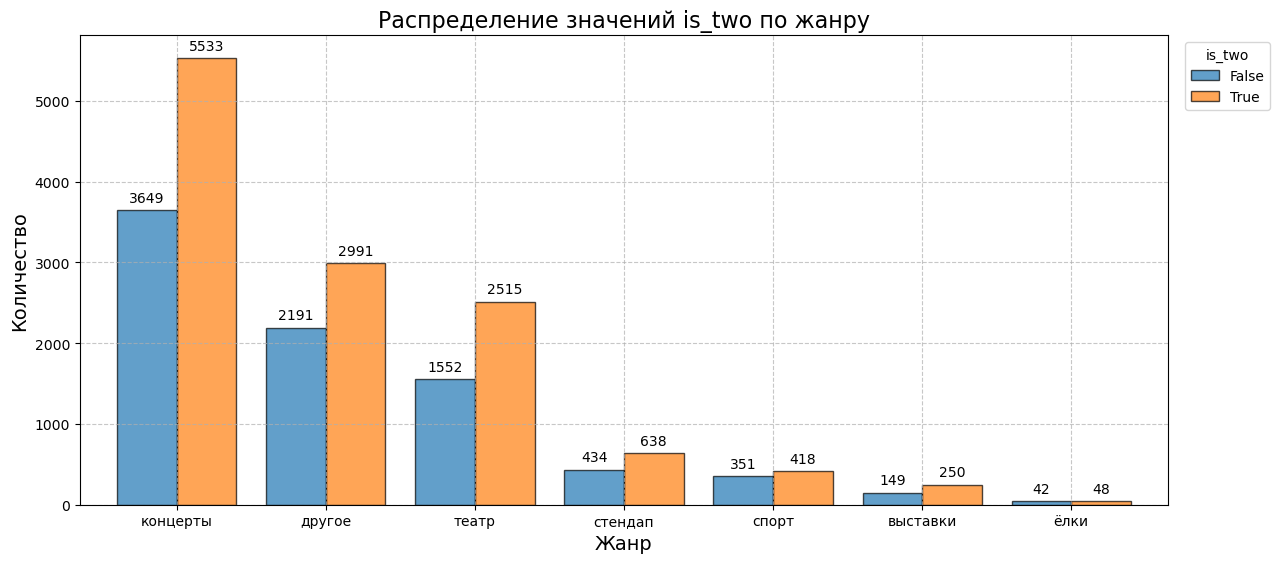

In [60]:
# по жанру
data = df_user.groupby('first_genre')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по жанру',
    xlabel='Жанр',
    ylabel='Количество',
    legend='is_two',
    yl=150
)

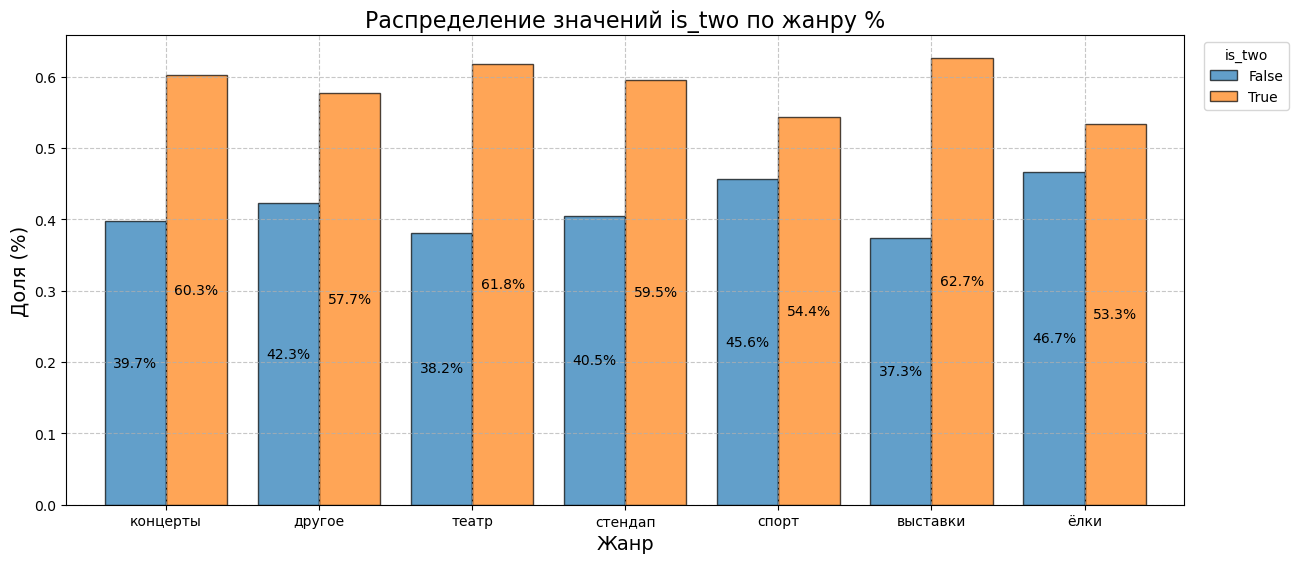

In [61]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по жанру %',
    xlabel='Жанр',
    ylabel='Доля (%)',
    fmt='{:.1%}',
    legend='is_two'
)

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\3435044935.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_user.groupby('first_device')['is_two'].value_counts().unstack(fill_value=0)


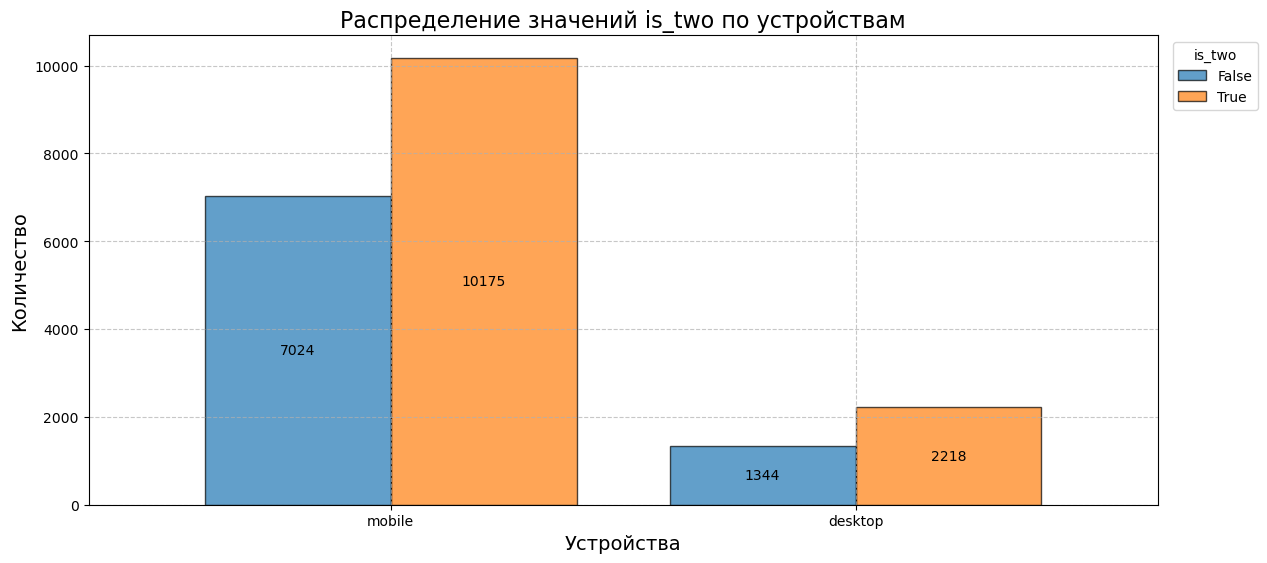

In [62]:
# по устройствам
data = df_user.groupby('first_device')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по устройствам',
    xlabel='Устройства',
    ylabel='Количество',
    legend='is_two',
)

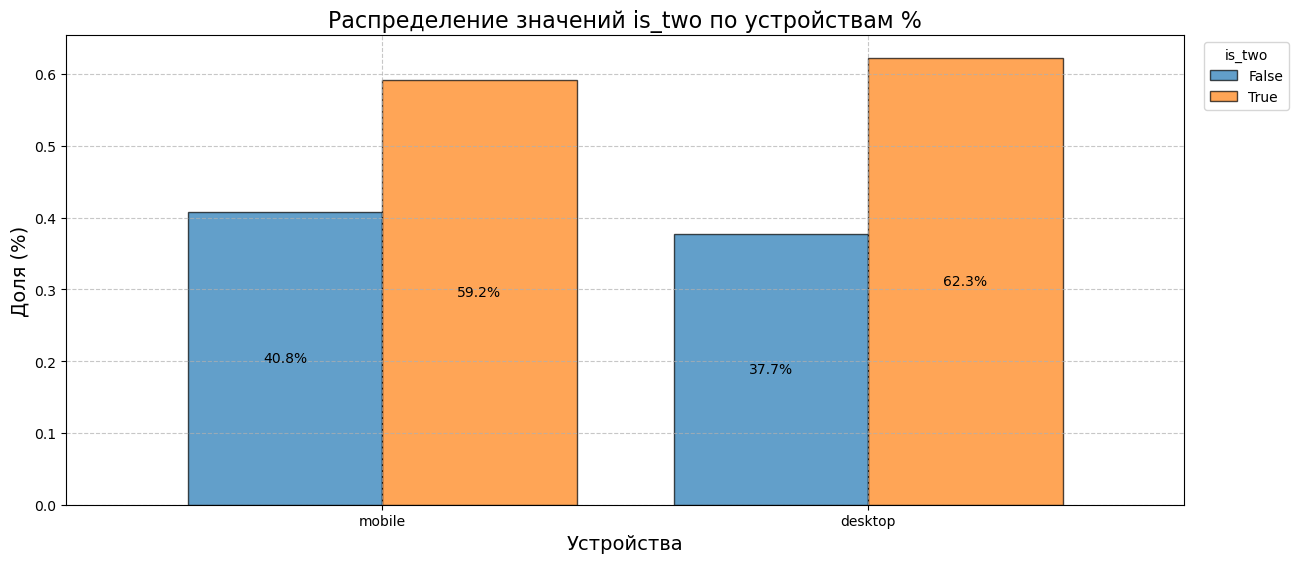

In [63]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по устройствам %',
    xlabel='Устройства',
    ylabel='Доля (%)',
    fmt='{:.1%}',
    legend='is_two'
)

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\424805857.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_user.groupby('first_region')['is_two'].value_counts().unstack(fill_value=0)


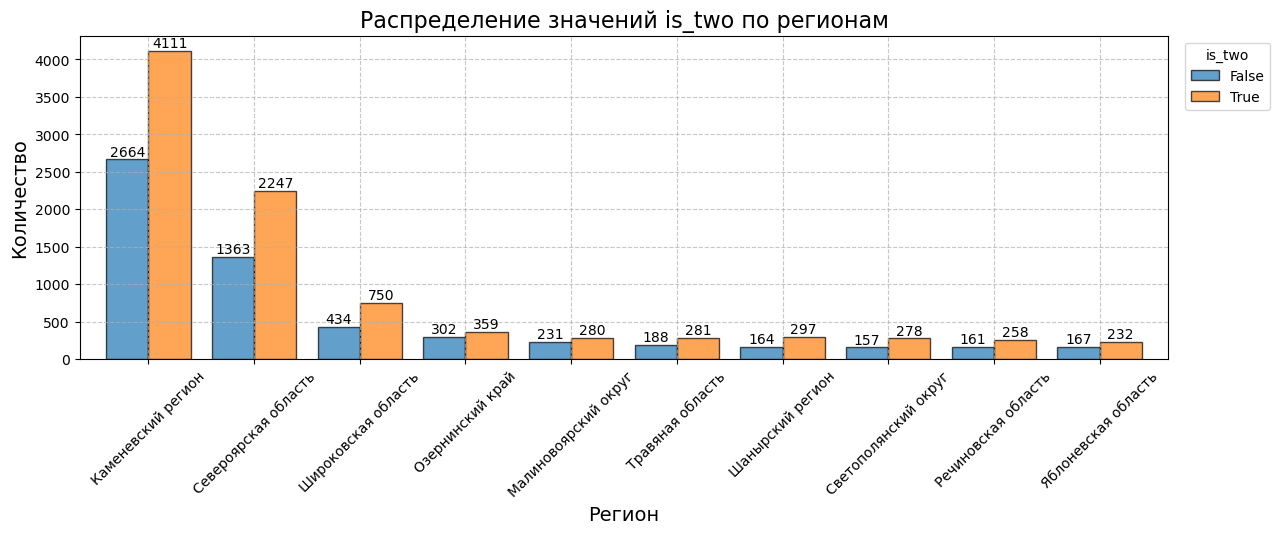

In [64]:
# по регионам
data = df_user.groupby('first_region')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по регионам',
    xlabel='Регион',
    ylabel='Количество',
    rot=45,
    legend='is_two',
    yl=100
)

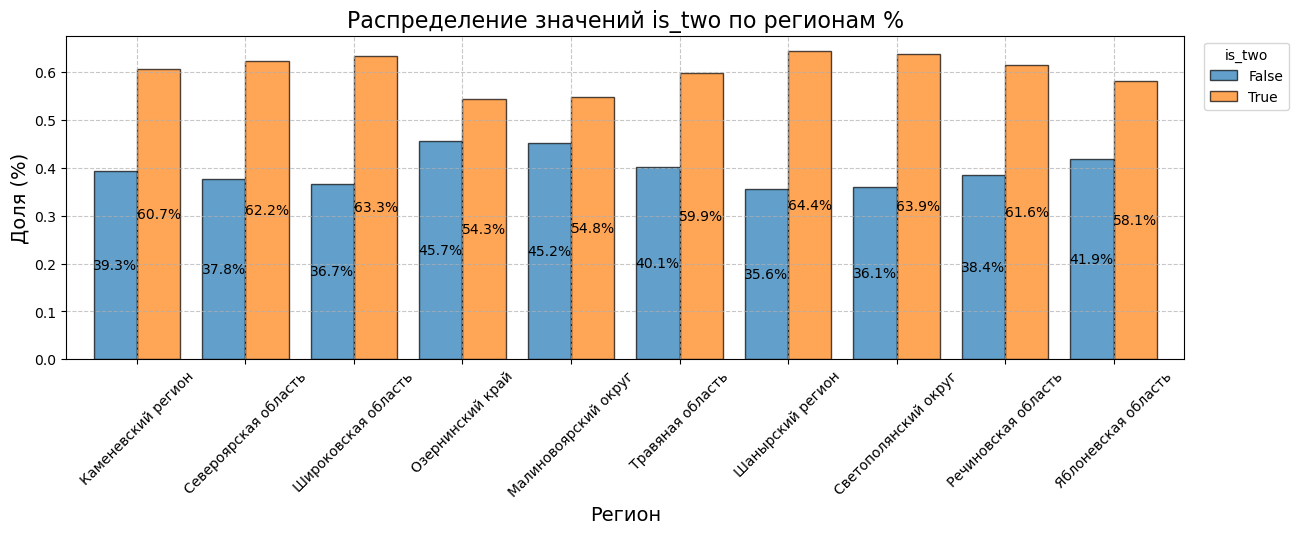

In [65]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по регионам %',
    xlabel='Регион',
    ylabel='Доля (%)',
    rot=45,
    fmt='{:.1%}',
    legend='is_two',
)

C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\410931128.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_user.groupby('first_partner')['is_two'].value_counts().unstack(fill_value=0)


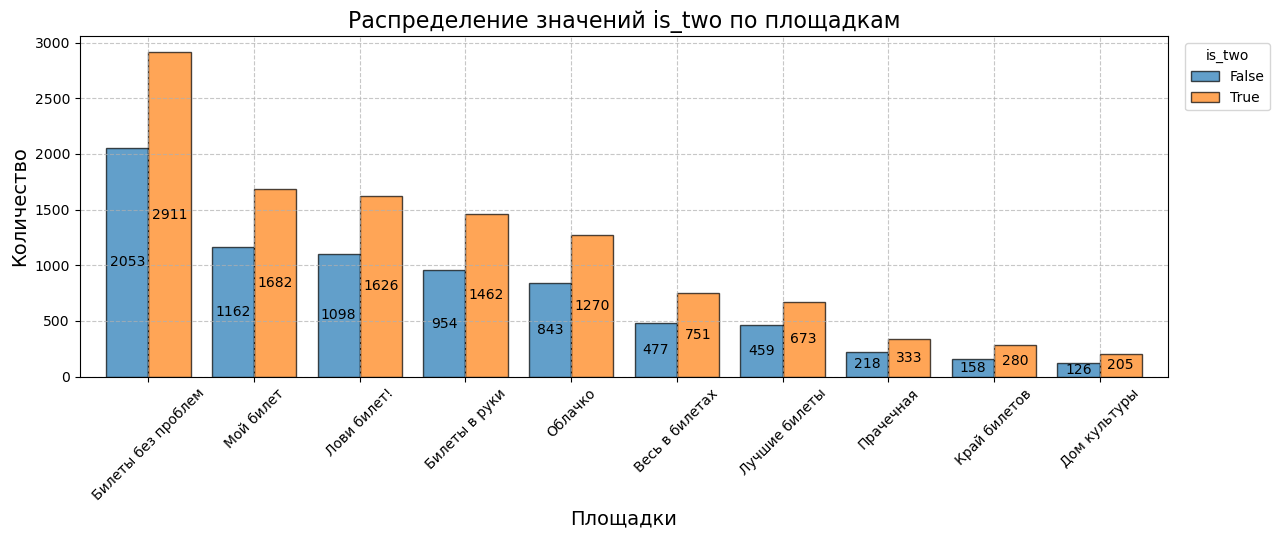

In [66]:
# по площадкам
data = df_user.groupby('first_partner')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по площадкам',
    xlabel='Площадки',
    ylabel='Количество',
    rot=45,
    legend='is_two',
)

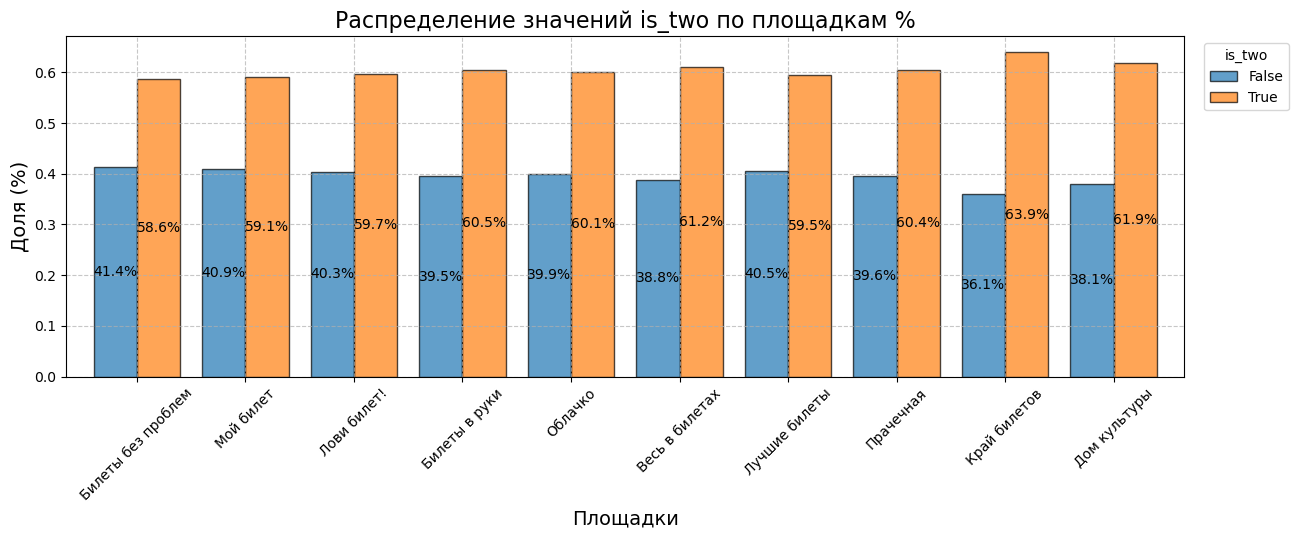

In [67]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по площадкам %',
    xlabel='Площадки',
    ylabel='Доля (%)',
    rot=45,
    fmt='{:.1%}',
    legend='is_two'
)

---
По жанру во всех сегментах представленных сотнями значений наблюдается более половины повторных заказов или около 60%. Нет зависимости от жанра.

В сегментах по устройствам так же порядка 60% заказов - повторные.

В топ-10 сегментах по регионам повторные заказы варьируются в диапазоне 54-64%, 

В топ-10 сегментах по платформам повторные заказы в среднем тоже близки к 60%.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Пользователей совершивших заказ повторно после спортивного мероприятия 54.4%. После концертов - 60.3%. При этом в абсолютных значениях после концертов 5533 пользователей совершили заказ повторно, а после спортинвых мероприятий всего 418.
Нельзя подтвердить Гипотезу 1.

По абсолютным значениям выделяются 2 региона, остальные меньше. Но тенденция одинакова для всех регионов, в среднем повторных заказов около 60% независмо от размера региона. Нельзя подтвердить Гипотезу 2

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


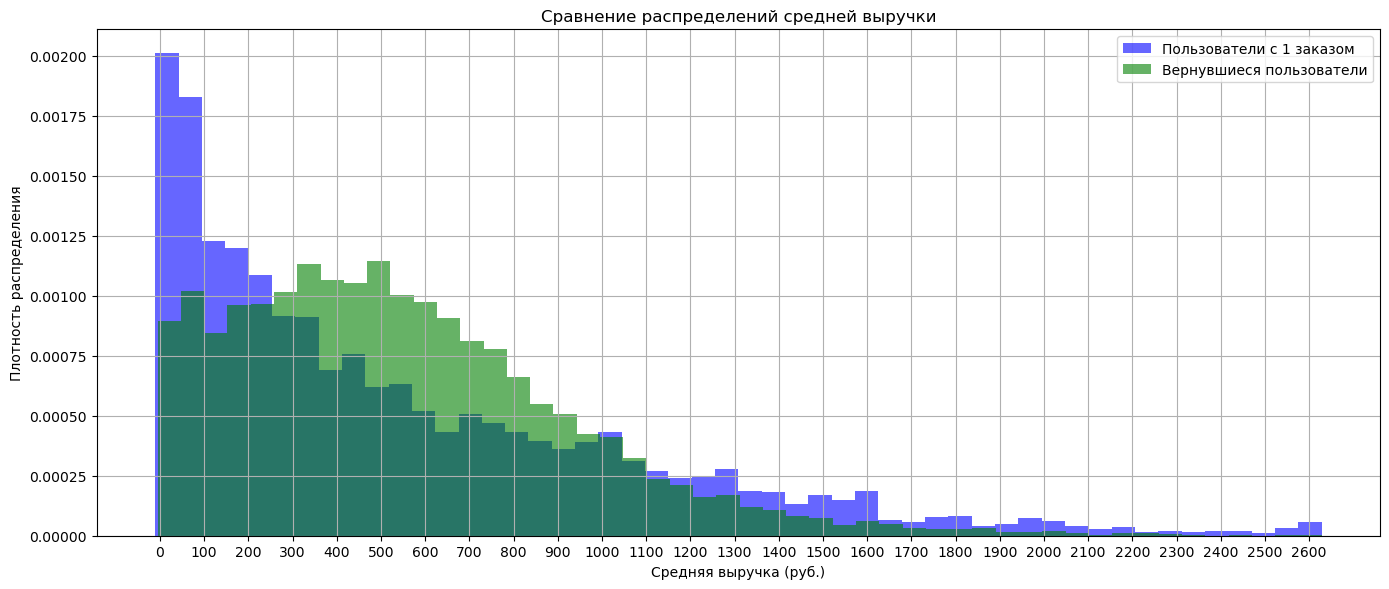

In [68]:
# Создаем график
plt.figure(figsize=(14, 6))

bins = 50
alpha = 0.6

plt.hist(df_user[~df_user.is_two]['avg_revenue_per_order'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Пользователи с 1 заказом',
         color='blue')

plt.hist(df_user[df_user.is_two]['avg_revenue_per_order'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся пользователи',
         color='green')

maxr = df_user['avg_revenue_per_order'].max() // 100 * 101
plt.xticks(np.arange(0, maxr, 100))

plt.title('Сравнение распределений средней выручки')
plt.xlabel('Средняя выручка (руб.)')
plt.ylabel('Плотность распределения')
plt.legend()

plt.grid()
plt.tight_layout()

plt.show()


---
Пользователи с единственным заказом сгруппрованы по значению средней выручки в диапазоне от 0 до 300р. и пиком в 0. Пользователи с единственным преобладают над пользователями с повторным заказом до значений выручки 250р.

Пользователи совершившие заказ повторно по средней выручке сгруппированы в диапазоне от 0 до 1000р. и пиком в 500р. Такие пользователи преобладают над пользовательми с одним заказом в окне 250-1000р.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


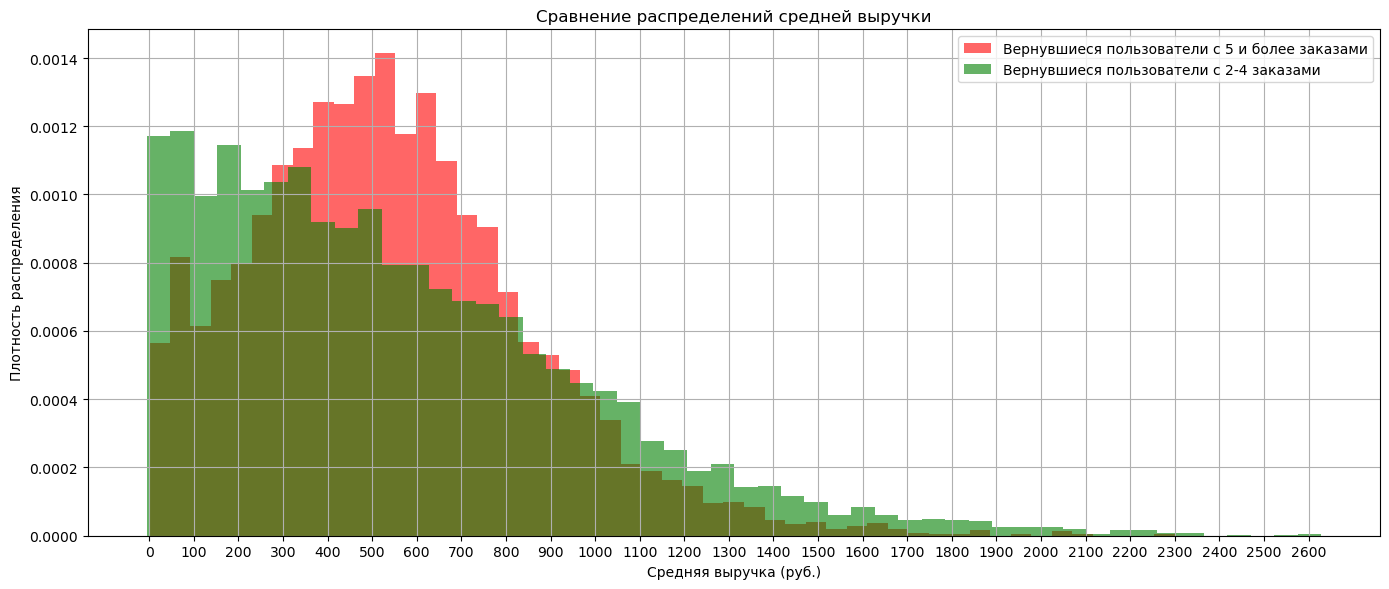

In [69]:
# Создаем график
plt.figure(figsize=(14, 6))

bins = 50
alpha = 0.6

plt.hist(df_user[df_user.is_five]['avg_revenue_per_order'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся пользователи с 5 и более заказами',
         color='red')

plt.hist(df_user[df_user.is_two & ~df_user.is_five]['avg_revenue_per_order'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся пользователи с 2-4 заказами',
         color='green')

maxr = df_user['avg_revenue_per_order'].max() // 100 * 101
plt.xticks(np.arange(0, maxr, 100))

plt.title('Сравнение распределений средней выручки')
plt.xlabel('Средняя выручка (руб.)')
plt.ylabel('Плотность распределения')
plt.legend()

plt.grid()
plt.tight_layout()

plt.show()

---
Для пользователей с 5 и более заказами пик смещен еще правее. Преобладание в диапазоне выручки 300-800р.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

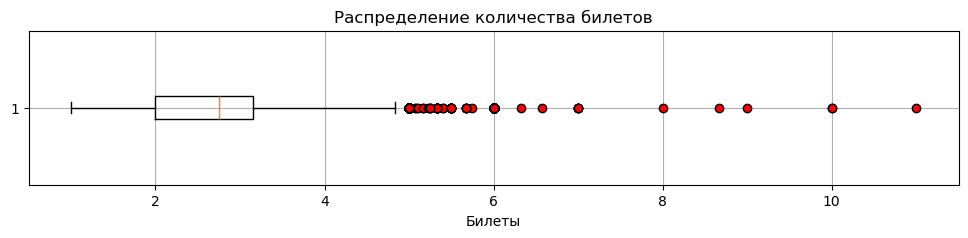

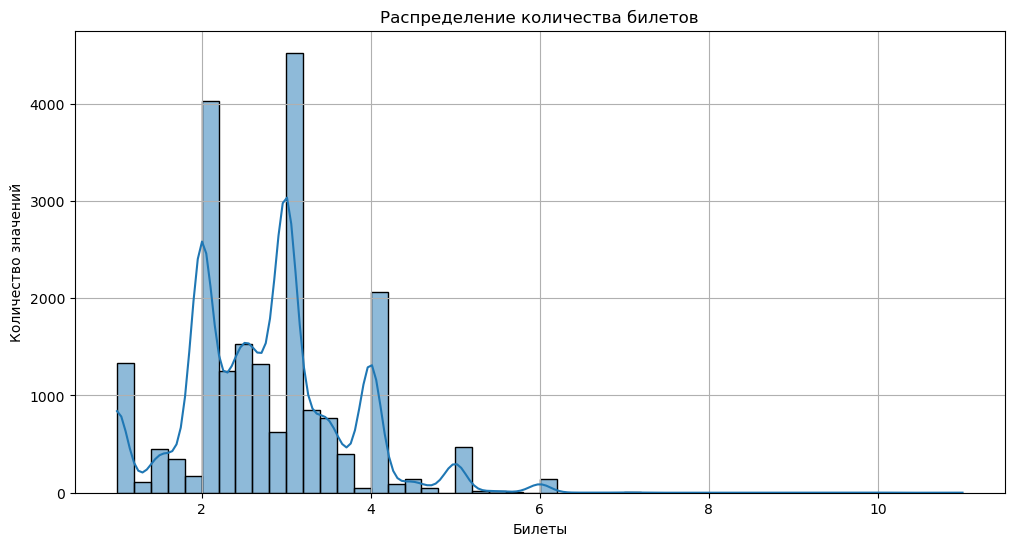

In [70]:
boxplot(df_user, 'avg_tickets_per_order', 'Распределение количества билетов', 'Билеты')
hist(df_user, 'avg_tickets_per_order', 'Распределение количества билетов', 'Билеты','Количество значений')

В основном покупают от 2 до 4 билетов. Покупки более 5 билетов - содержат выбросы.

In [71]:
# сформируем сегменты по билетам
df_user['ticket_segment'] = pd.cut(
    df_user['avg_tickets_per_order'],
    bins=[1, 2, 3, 5, np.inf],labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов'],
    right=False
)
df_user.head()

,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders,is_two,is_five,ticket_segment
user_id,,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,NaN,False,False,3-5 билетов
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.0,True,False,3-5 билетов
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.0,True,False,2-3 билета
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,NaN,False,False,3-5 билетов
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,True,False,1-2 билета


C:\Users\Andrey\AppData\Local\Temp\ipykernel_12976\2897883549.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df_user.groupby('ticket_segment')['is_two'].value_counts().unstack(fill_value=0)


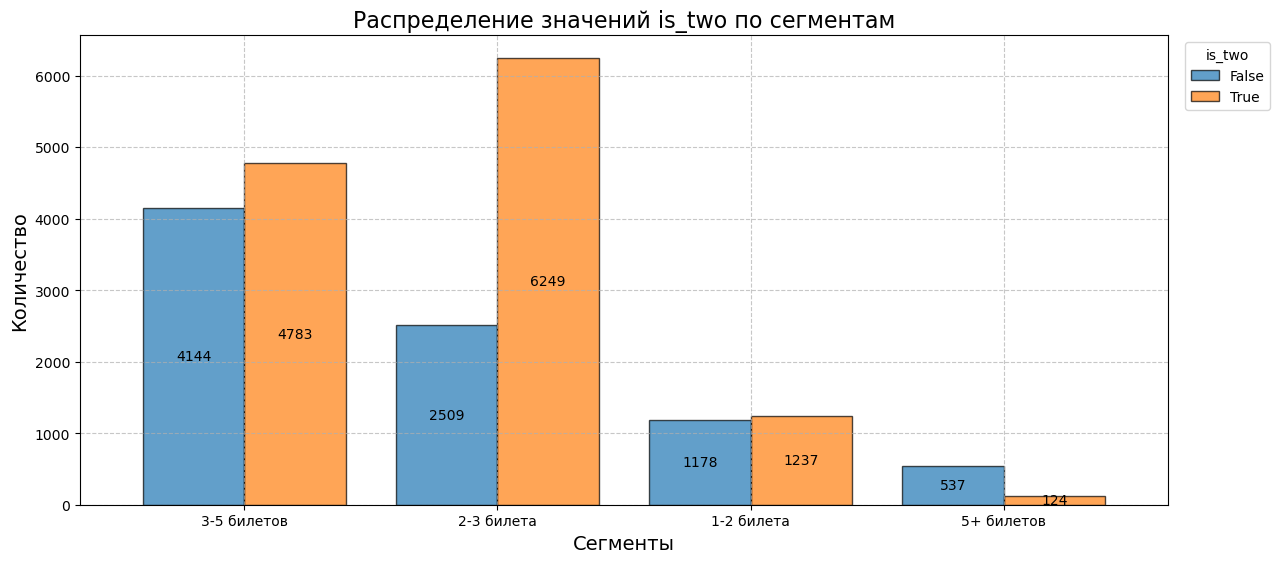

In [72]:
# по сегментам с выделением совершивших повторный заказ
data = df_user.groupby('ticket_segment')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по сегментам',
    xlabel='Сегменты',
    ylabel='Количество',
    legend='is_two',
)

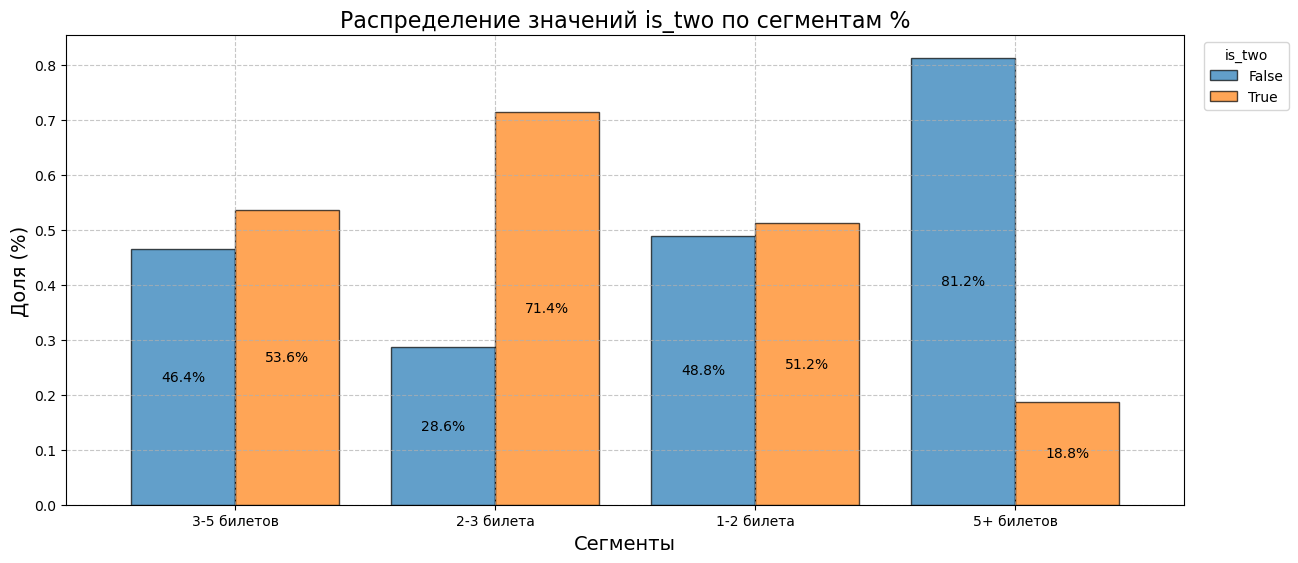

In [73]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по сегментам %',
    xlabel='Сегменты',
    ylabel='Доля (%)',
    fmt='{:.1%}',
    legend='is_two'
)

Сегменты, суммарно представленные менее чем 3000 покупок:
- Менее 19% повторных покупок в сегменте *5+ билетов*
- 51% повторных покупок в сегменте *1-2 билета*

Сегменты, имеющие почти 9000 покупок каждый:
- 54% повторных покупок в сегменте *3-5 билетов*
- 71% покупок в сегменте *2-3 билета*

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [74]:
# сохраним день недели
df_user['day_of_week'] = df_user['first_order_date'].dt.day_name()
df_user.head()

,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_days_between_orders,is_two,is_five,ticket_segment,day_of_week
user_id,,,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,NaN,False,False,3-5 билетов,Tuesday
0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.0,True,False,3-5 билетов,Tuesday
000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.0,True,False,2-3 билета,Saturday
00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,NaN,False,False,3-5 билетов,Thursday
000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,True,False,1-2 билета,Sunday


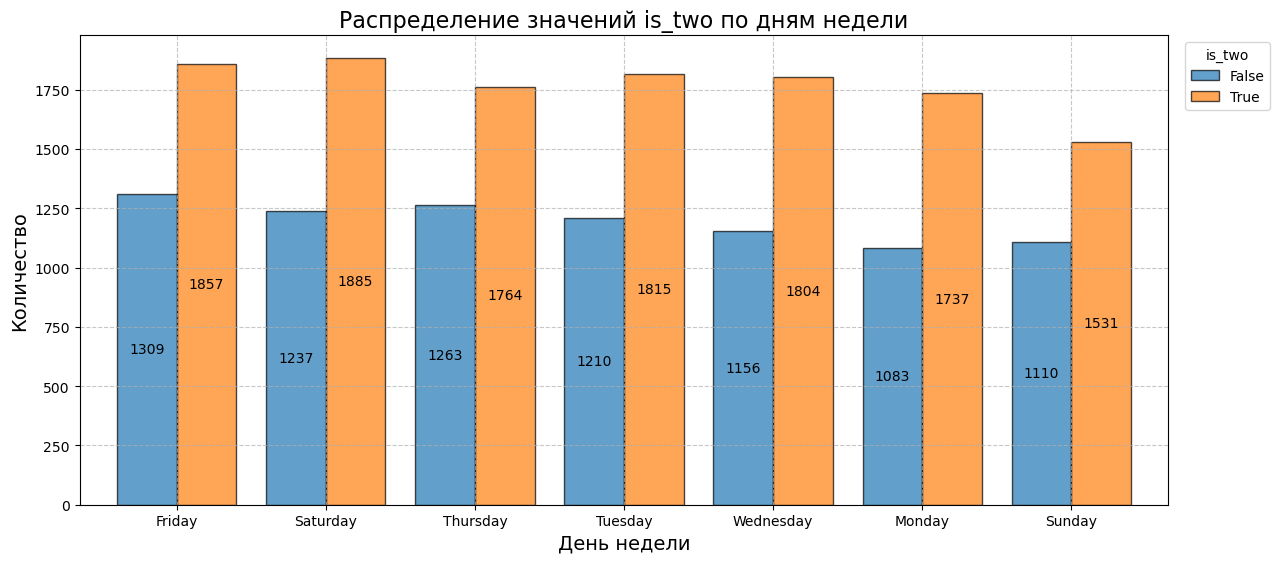

In [75]:
# по сегментам с выделением совершивших повторный заказ
data = df_user.groupby('day_of_week')['is_two'].value_counts().unstack(fill_value=0)
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index].head(10)

plot_bar(
    data=data,
    title='Распределение значений is_two по дням недели',
    xlabel='День недели',
    ylabel='Количество',
    legend='is_two',
)

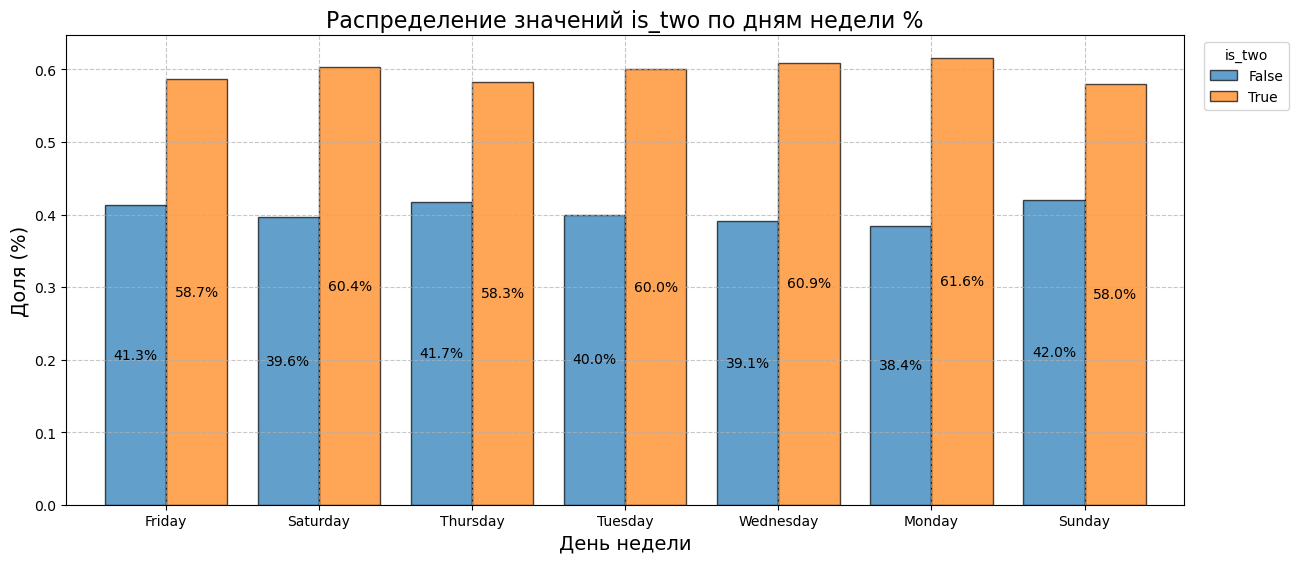

In [76]:
data = data.div(data.sum(axis=1), axis=0)
plot_bar(
    data=data,
    title='Распределение значений is_two по дням недели %',
    xlabel='День недели',
    ylabel='Доля (%)',
    fmt='{:.1%}',
    legend='is_two'
)

---
День недели не влияет на вероятность совершения клиентом повторной покупки. Гипотеза не подтверждается.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [77]:
df_user[df_user.is_five]['avg_days_between_orders'].describe()

count    5245.000000
mean       11.124936
std         7.776422
min         0.000000
25%         5.580000
50%         9.550000
75%        15.400000
max        37.500000
Name: avg_days_between_orders, dtype: float64

In [78]:
df_user[df_user.is_two & ~df_user.is_five]['avg_days_between_orders'].describe()

count    7148.000000
mean       21.328538
std        28.482864
min         0.000000
25%         0.000000
50%         9.000000
75%        34.000000
max       148.000000
Name: avg_days_between_orders, dtype: float64

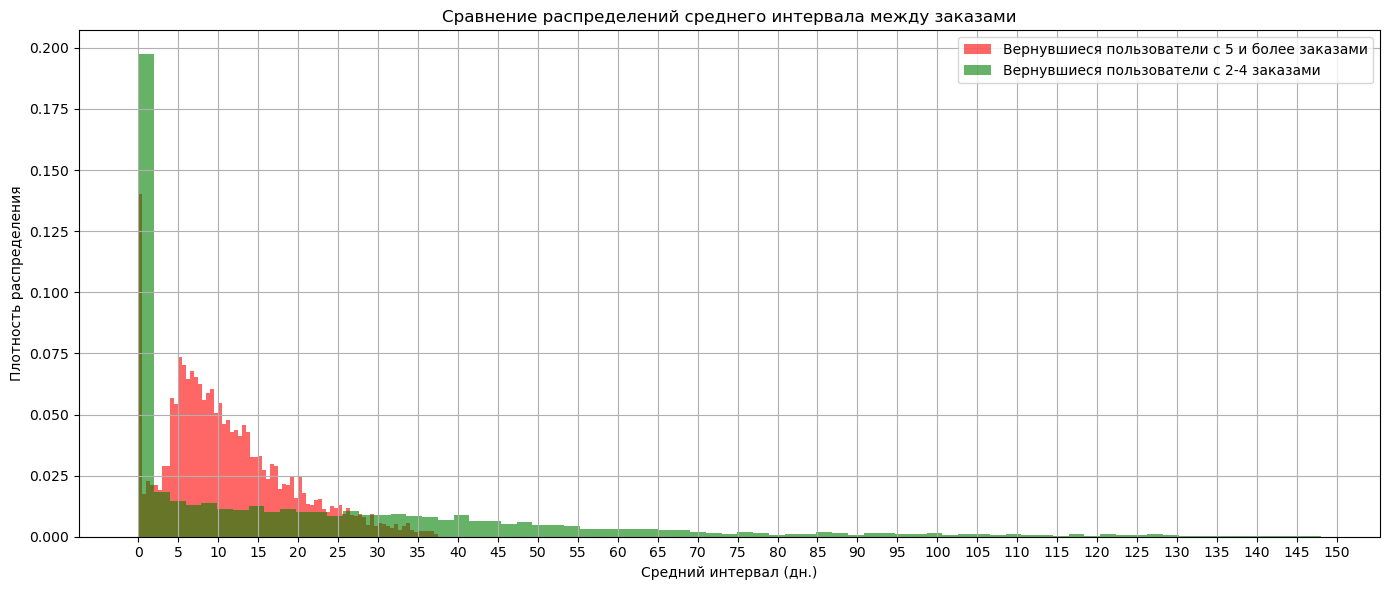

In [79]:
# Создаем график
plt.figure(figsize=(14, 6))

bins = 75
alpha = 0.6

plt.hist(df_user[df_user.is_five]['avg_days_between_orders'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся пользователи с 5 и более заказами',
         color='red')

plt.hist(df_user[df_user.is_two & ~df_user.is_five]['avg_days_between_orders'], 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся пользователи с 2-4 заказами',
         color='green')

maxr = df_user['avg_days_between_orders'].max() // 10 * 11
plt.xticks(np.arange(0, maxr, 5))

plt.title('Сравнение распределений среднего интервала между заказами')
plt.xlabel('Средний интервал (дн.)')
plt.ylabel('Плотность распределения')
plt.legend()

plt.grid()
plt.tight_layout()

plt.show()

---
Для пользователей с 5 и более заказами - два пика, в районе интервалов: 0 дней и 5 дней.

Для пользователей с 2-4 заказами пик в районе интервалов 0-1 дней.

Оба сегмента пользователей заказывают билет повторно или в тот же день или на следующий.

В сегменте с 5 и более заказами пользователи совершают повторную покупку через неделю чаще чем пользоватили с 2-4 заказами. Далее тенденция идет на спад, но в течение месяца вероятность совершить покупку у таких пользователей все равно выше чем у пользователей с 2-4 заказами.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [80]:
# вычислить матрицу корреляций
corr_matrix = df_user.phik_matrix(interval_cols=['avg_revenue_per_order', 'avg_tickets_per_order', 'avg_days_between_orders'])

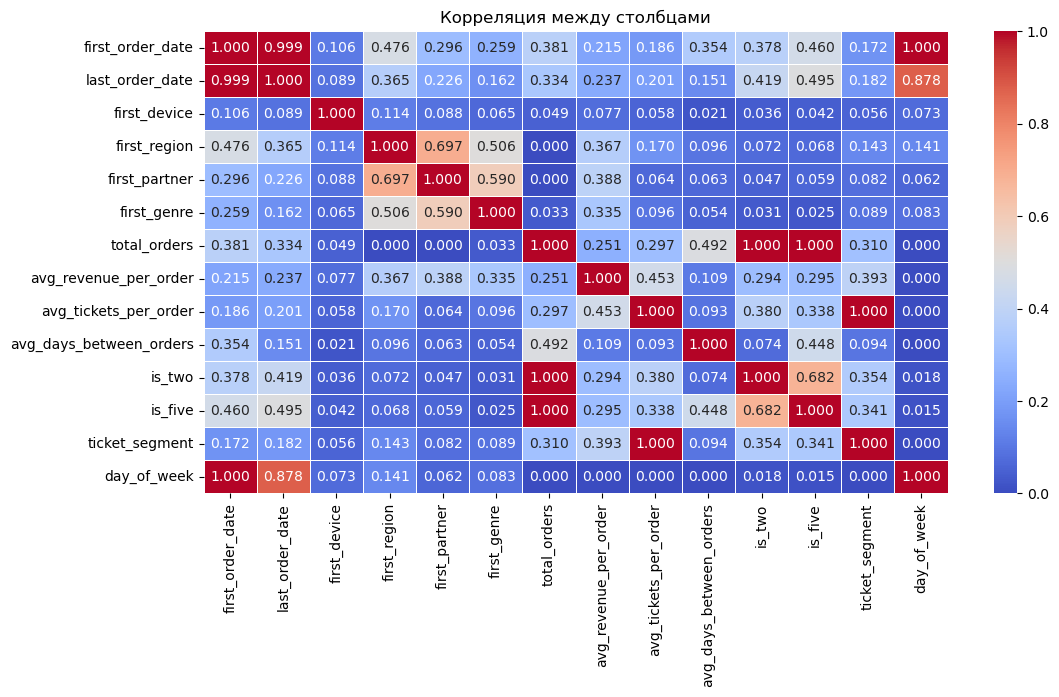

In [81]:
plt.figure(figsize=(12, 6))

sns.heatmap(data=corr_matrix, annot=True, fmt='.3f', linewidths=0.5, cmap='coolwarm')

plt.title('Корреляция между столбцами')
plt.show()

Потенциальные интересные корреляции:
- регион и партнер 0.697
- жанр и партнер 0.588

Количество заказов коррелирует с признаками `is_two` и `is_five`,т.к. они созданы на его основе. Аналогичная ситуация для сегментов по количеству билетов и для признака дня недели.

In [82]:
# функция для поторных рассчетов корреляции по total_orders
def corr(df,
         title='',
         column='total_orders',
         interval_cols=['avg_revenue_per_order', 'avg_tickets_per_order', 'avg_days_between_orders']
        ):
    corr_matrix = df.phik_matrix(interval_cols=interval_cols, verbose=False)
    
    data_heatmap = corr_matrix.loc[corr_matrix.index != column][[column]].sort_values(by=column, ascending=False)

    plt.figure(figsize=(2, 6))
    sns.heatmap(
        data_heatmap,
        annot=True,
        fmt='.3f', 
        cmap='coolwarm', 
        linewidths=0.5,
        cbar=False 
    )
    
    plt.xlabel('Заказы')
        
    plt.title(title)
        
    plt.show()

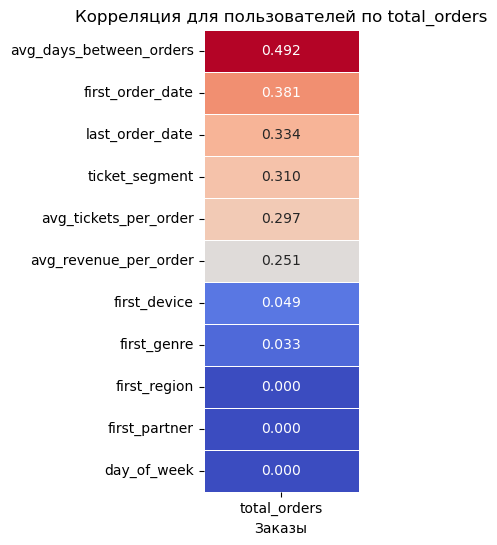

In [83]:
# корреляция для total_orders

corr(df_user.drop(columns=['is_two', 'is_five']),
    'Корреляция для пользователей по total_orders')

In [84]:
# Корреляция для пользователей c 1 заказом не сработает т.к. в total_orders будут только значение 1.

# Not enough unique value for variable total_orders for analysis 1. Dropping this column

# corr(df_user[~df_user.is_two].drop(columns=['is_two', 'is_five']),
#    'Корреляция для пользователей c 1 заказом')

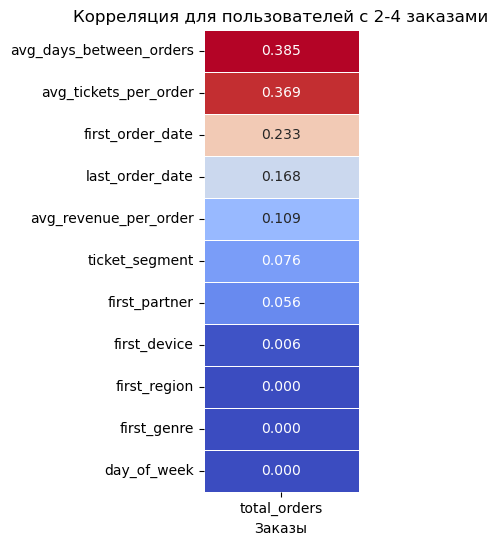

In [85]:
corr(df_user[df_user.is_two & ~df_user.is_five].drop(columns=['is_two', 'is_five']),
    'Корреляция для пользователей c 2-4 заказами')

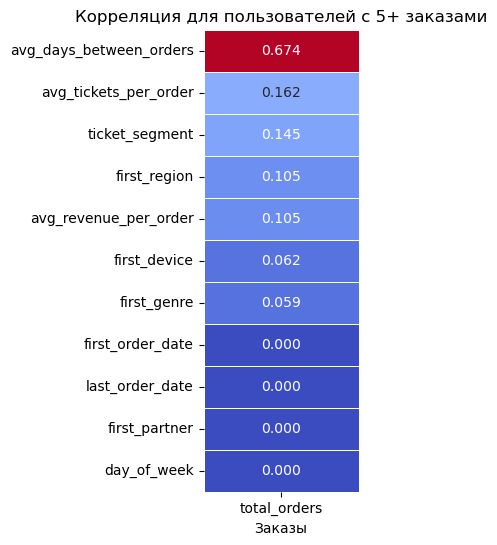

In [86]:
corr(df_user[df_user.is_five].drop(columns=['is_two', 'is_five']),
    'Корреляция для пользователей c 5+ заказами')

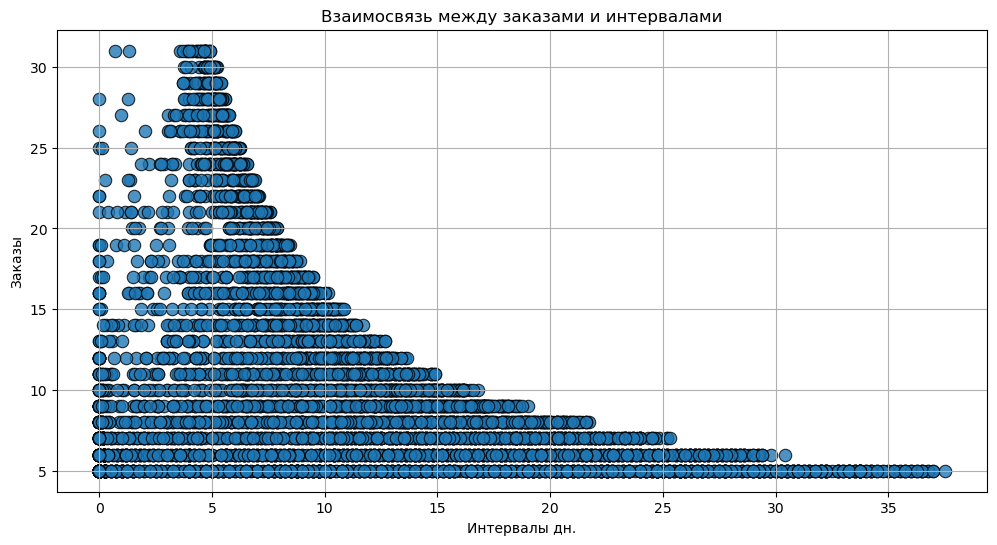

In [87]:
# для сегмента с наибольшим значением коэффициента отобразим на графике
data = df_user[df_user.is_five]
data.plot(kind='scatter',
          x='avg_days_between_orders',
          y='total_orders',
          marker='o', 
          s=80,
          alpha=0.8,
          edgecolor='black',
          linewidth=0.8,
         )

plt.title('Взаимосвязь между заказами и интервалами')
plt.xlabel('Интервалы дн.')
plt.ylabel('Заказы')
plt.grid()

plt.gcf().set_size_inches(12,6)
plt.show() 

---
Для общего числа заказов пользователя видна корреляция с количеством дней между заказами.
- 0.492 общая
- 0.385 для сегмента 2-4 заказа 
- 0.674 для сегмента 5+ заказов

---
<a name="5"></a>
### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

---
**Подготовка данных**

Исходная выборка: 290 611 записей за период июнь-октябрь 2024 года.

Финальная выборка: 287 755 записей. Были удалены 31 дубликат и 2 825 записей с выбросами по выручке.

Дополнительные преобразования:
- Перевод выручки из тенге в рубли
- Приведение типов данных для оптимизации памяти
- Создание метрик пользовательского профиля

После фильтрации данных по 95 процентилю из-за выбросов по количеству заказов осталось записей пользователей: 20761. Удалено: 1093.

**Анализ** 

Распределение пользователей:
- 60% пользователей совершили 2 и более заказов
- 25% пользователей совершили 5 и более заказов

Характеристики первого заказа:
- 83% заказов совершено с мобильных устройств

Топ-жанры: 
- 44% концерты (9182)
- 25% другое (5182)
- 20% театр (4067)

Лидеры по регионам: 
- 33% Каменевский (6775)
- 17% Североярский (3610)

В топ-5 площадки с показателем более 10% пользователей:
- 24% Билеты без проблем (4964)
- 14% Мой билет (2844)
- 13% Лови билет! (2724)
- 12% Билеты в руки (2416)
- 10% Облачко (2113)

**Факторы удержания пользователей**

Повторные покупки:
- В среднем 60% повторных заказов во всех сегментах
- Нет зависимости от жанра мероприятия

Выручка и количество билетов:
- Пользователи с выручкой >250 руб. чаще возвращаются
- Сегмент пользователей купивших 2-3 билета имеет 71% повторных покупок
- Сегмент 3-5 билетов — 54% повторных покупок

**Временные характеристики**

- Нет влияния дня недели на повторные покупки

Интервалы между покупками:
- Пользователи с 2-4 заказами: пик повторных покупок приходится на 0-1 день
- Пользователи с 5+ заказами: пик такой же как и упользователей с 2-4 заказами, а также пик повторных покупок спустя неделю после последней покупки.

Также у пользователей с 5+ заказами в течение месяца удержание остается на уровне выше чем у пользователей с 2-4 заказами.

**Корреляционный анализ**

Связи между исследуемыми параметрами:
- Количество заказов и интервалы между ними (0.492)
- Регион и партнер (0.697)
- Жанр и партнер (0.588)

**Рекомендации**

По приоритетным сегментам:
- Пользователи с заказами 2-3 билета (71% повторных покупок)
- Сегмент 3-5 билетов (54% повторных покупок)
- Активные пользователи с 5+ заказами

Возможно, подумать о развитии партнерских отношений в топовых регионах и с площадками-лидерами для привлечения новых пользователей и увеличения активности пользователей с 1 заказом.

Подумать, как удерживать пользователей приоритетных сегментов. Например, рассылка предложений на следующий день после покупки билетов. Или рассылать специальные предложения и скидки через неделю, месяц — для активных пользователей.

--[Вернуться в начало](#0)--

---
<a name="6"></a>
### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/androverx/YP-afisha.git